In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the AUC results
auc_df = pd.read_csv("auc_scores_with_rf_kappa_thresholding_detailed.csv")
auc_df["Random_AUCPR"] = auc_df["Total Actives Test"]/(auc_df["Total Inactives Test"] + auc_df["Total Actives Test"])

# Group by Task (Assay) and Feature Set to compute summary statistics
summary_stats = auc_df.groupby(["Task", "Feature Set"])["AUC"].agg(["mean", "std", "count"]).reset_index()


# Compare the overall performance across feature sets
overall_comparison = auc_df.groupby("Feature Set")["AUC"].agg(["mean", "std"]).reset_index()


In [15]:
auc_df

,Feature Set,Fold,Task,AUC,Optimal Threshold,Optimal Kappa,Kappa,Kappa @ 0.50,Balanced Accuracy,AUCPR,...,FN,Total Actives Train,Total Inactives Train,Total Compounds Train,Total Actives Test,Total Inactives Test,Total Compounds Test,Scrambled Kappa,Scrambled Balanced Accuracy,Random_AUCPR
0,CellCount,1,CHEMBL1741321,0.604340,0.515152,0.216561,0.139751,0.079476,0.584891,0.347446,...,32,155,409,564,77,205,282,0.000000,0.500000,0.273050
1,CellCount,2,CHEMBL1741321,0.610073,0.525253,0.177223,0.242978,0.094627,0.617548,0.367448,...,45,155,409,564,77,205,282,0.000000,0.500000,0.273050
2,CellCount,3,CHEMBL1741321,0.621009,0.515152,0.174249,0.223471,0.121560,0.623680,0.341822,...,35,154,410,564,78,204,282,0.000000,0.500000,0.276596
3,CellProfiler,1,CHEMBL1741321,0.639024,0.323232,0.301274,0.185959,0.114798,0.602027,0.407417,...,38,155,409,564,77,205,282,-0.020907,0.492683,0.273050
4,CellProfiler,2,CHEMBL1741321,0.615394,0.424242,0.220567,0.211821,0.182473,0.590022,0.455906,...,56,155,409,564,77,205,282,0.018771,0.506494,0.273050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,CellCount,2,CHEMBL5291899,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.647059,...,0,21,48,69,10,24,34,0.000000,0.500000,0.294118
134,CellCount,3,CHEMBL5291899,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.647059,...,0,21,48,69,10,24,34,0.000000,0.500000,0.294118
135,CellProfiler,1,CHEMBL5291899,0.348485,0.373737,0.330709,-0.229205,-0.107056,0.382576,0.245014,...,9,20,48,68,11,24,35,-0.201373,0.416667,0.314286
136,CellProfiler,2,CHEMBL5291899,0.608333,0.242424,0.076305,0.126888,0.000000,0.587500,0.323211,...,2,21,48,69,10,24,34,0.135593,0.550000,0.294118


In [20]:
df = auc_df

In [62]:
# Find maximum AUCPR for CellCount and Random_AUCPR per task
cellcount_random_max = df[df["Feature Set"] == "CellCount"].groupby(["Task", "Fold"])[["AUCPR", "Random_AUCPR"]].max()
cellcount_random_max["Max_CellCount_Random_AUCPR"] = cellcount_random_max[["AUCPR", "Random_AUCPR"]].max(axis=1)

# Merge the maximum CellCount/Random_AUCPR back with CellProfiler data
cellprofiler_df = df[df["Feature Set"] == "CellProfiler"].merge(cellcount_random_max["Max_CellCount_Random_AUCPR"], on=["Task", "Fold"])

# Compare CellProfiler AUCPR with the max of CellCount/Random_AUCPR for each task
cellprofiler_df["Better_AUCPR"] = cellprofiler_df["AUCPR"] >= cellprofiler_df["Max_CellCount_Random_AUCPR"]

# Count how many times CellProfiler AUCPR is better per task
better_aucpr_counts_corrected = cellprofiler_df.groupby("Task")["Better_AUCPR"].sum()

better_aucpr_counts_corrected


Task
CHEMBL1741321    3
CHEMBL1741322    3
CHEMBL1741323    3
CHEMBL1741324    3
CHEMBL1741325    3
CHEMBL1909087    1
CHEMBL1909089    2
CHEMBL1909104    0
CHEMBL1909105    1
CHEMBL1909141    1
CHEMBL1909156    3
CHEMBL1909211    1
CHEMBL5291731    2
CHEMBL5291732    1
CHEMBL5291781    0
CHEMBL5291782    1
CHEMBL5291809    1
CHEMBL5291815    0
CHEMBL5291818    0
CHEMBL5291822    3
CHEMBL5291850    3
CHEMBL5291892    0
CHEMBL5291899    0
Name: Better_AUCPR, dtype: int64

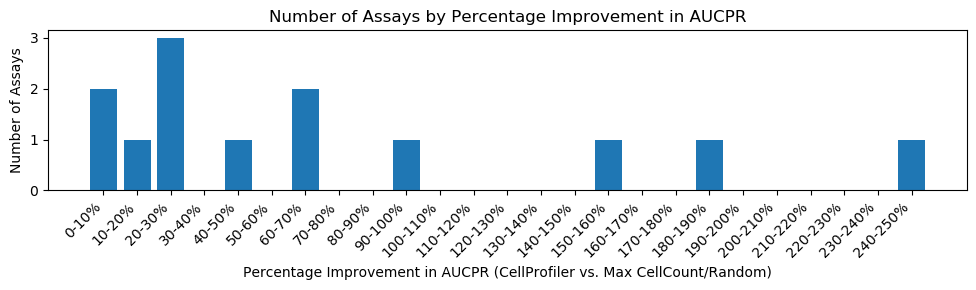

In [63]:
import matplotlib.pyplot as plt

# Calculate percentage improvement for CellProfiler AUCPR compared to max of CellCount/Random AUCPR
cellprofiler_df["Percentage_Improvement"] = (
    (cellprofiler_df["AUCPR"] - cellprofiler_df["Max_CellCount_Random_AUCPR"]) / cellprofiler_df["Max_CellCount_Random_AUCPR"]
) * 100


cellprofiler_df = cellprofiler_df.groupby("Task").mean().reset_index()

# Bin percentage improvement into ranges
bins = range(0, 251, 10)  # Define bins from -50% to 100% in increments of 10%
cellprofiler_df["Improvement_Bin"] = pd.cut(cellprofiler_df["Percentage_Improvement"], bins)

# Count the number of assays in each bin
improvement_counts = cellprofiler_df["Improvement_Bin"].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 3))
plt.bar(
    [f"{int(interval.left)}-{int(interval.right)}%" for interval in improvement_counts.index],
    improvement_counts.values,
)
plt.xlabel("Percentage Improvement in AUCPR (CellProfiler vs. Max CellCount/Random)")
plt.ylabel("Number of Assays")
plt.title("Number of Assays by Percentage Improvement in AUCPR")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


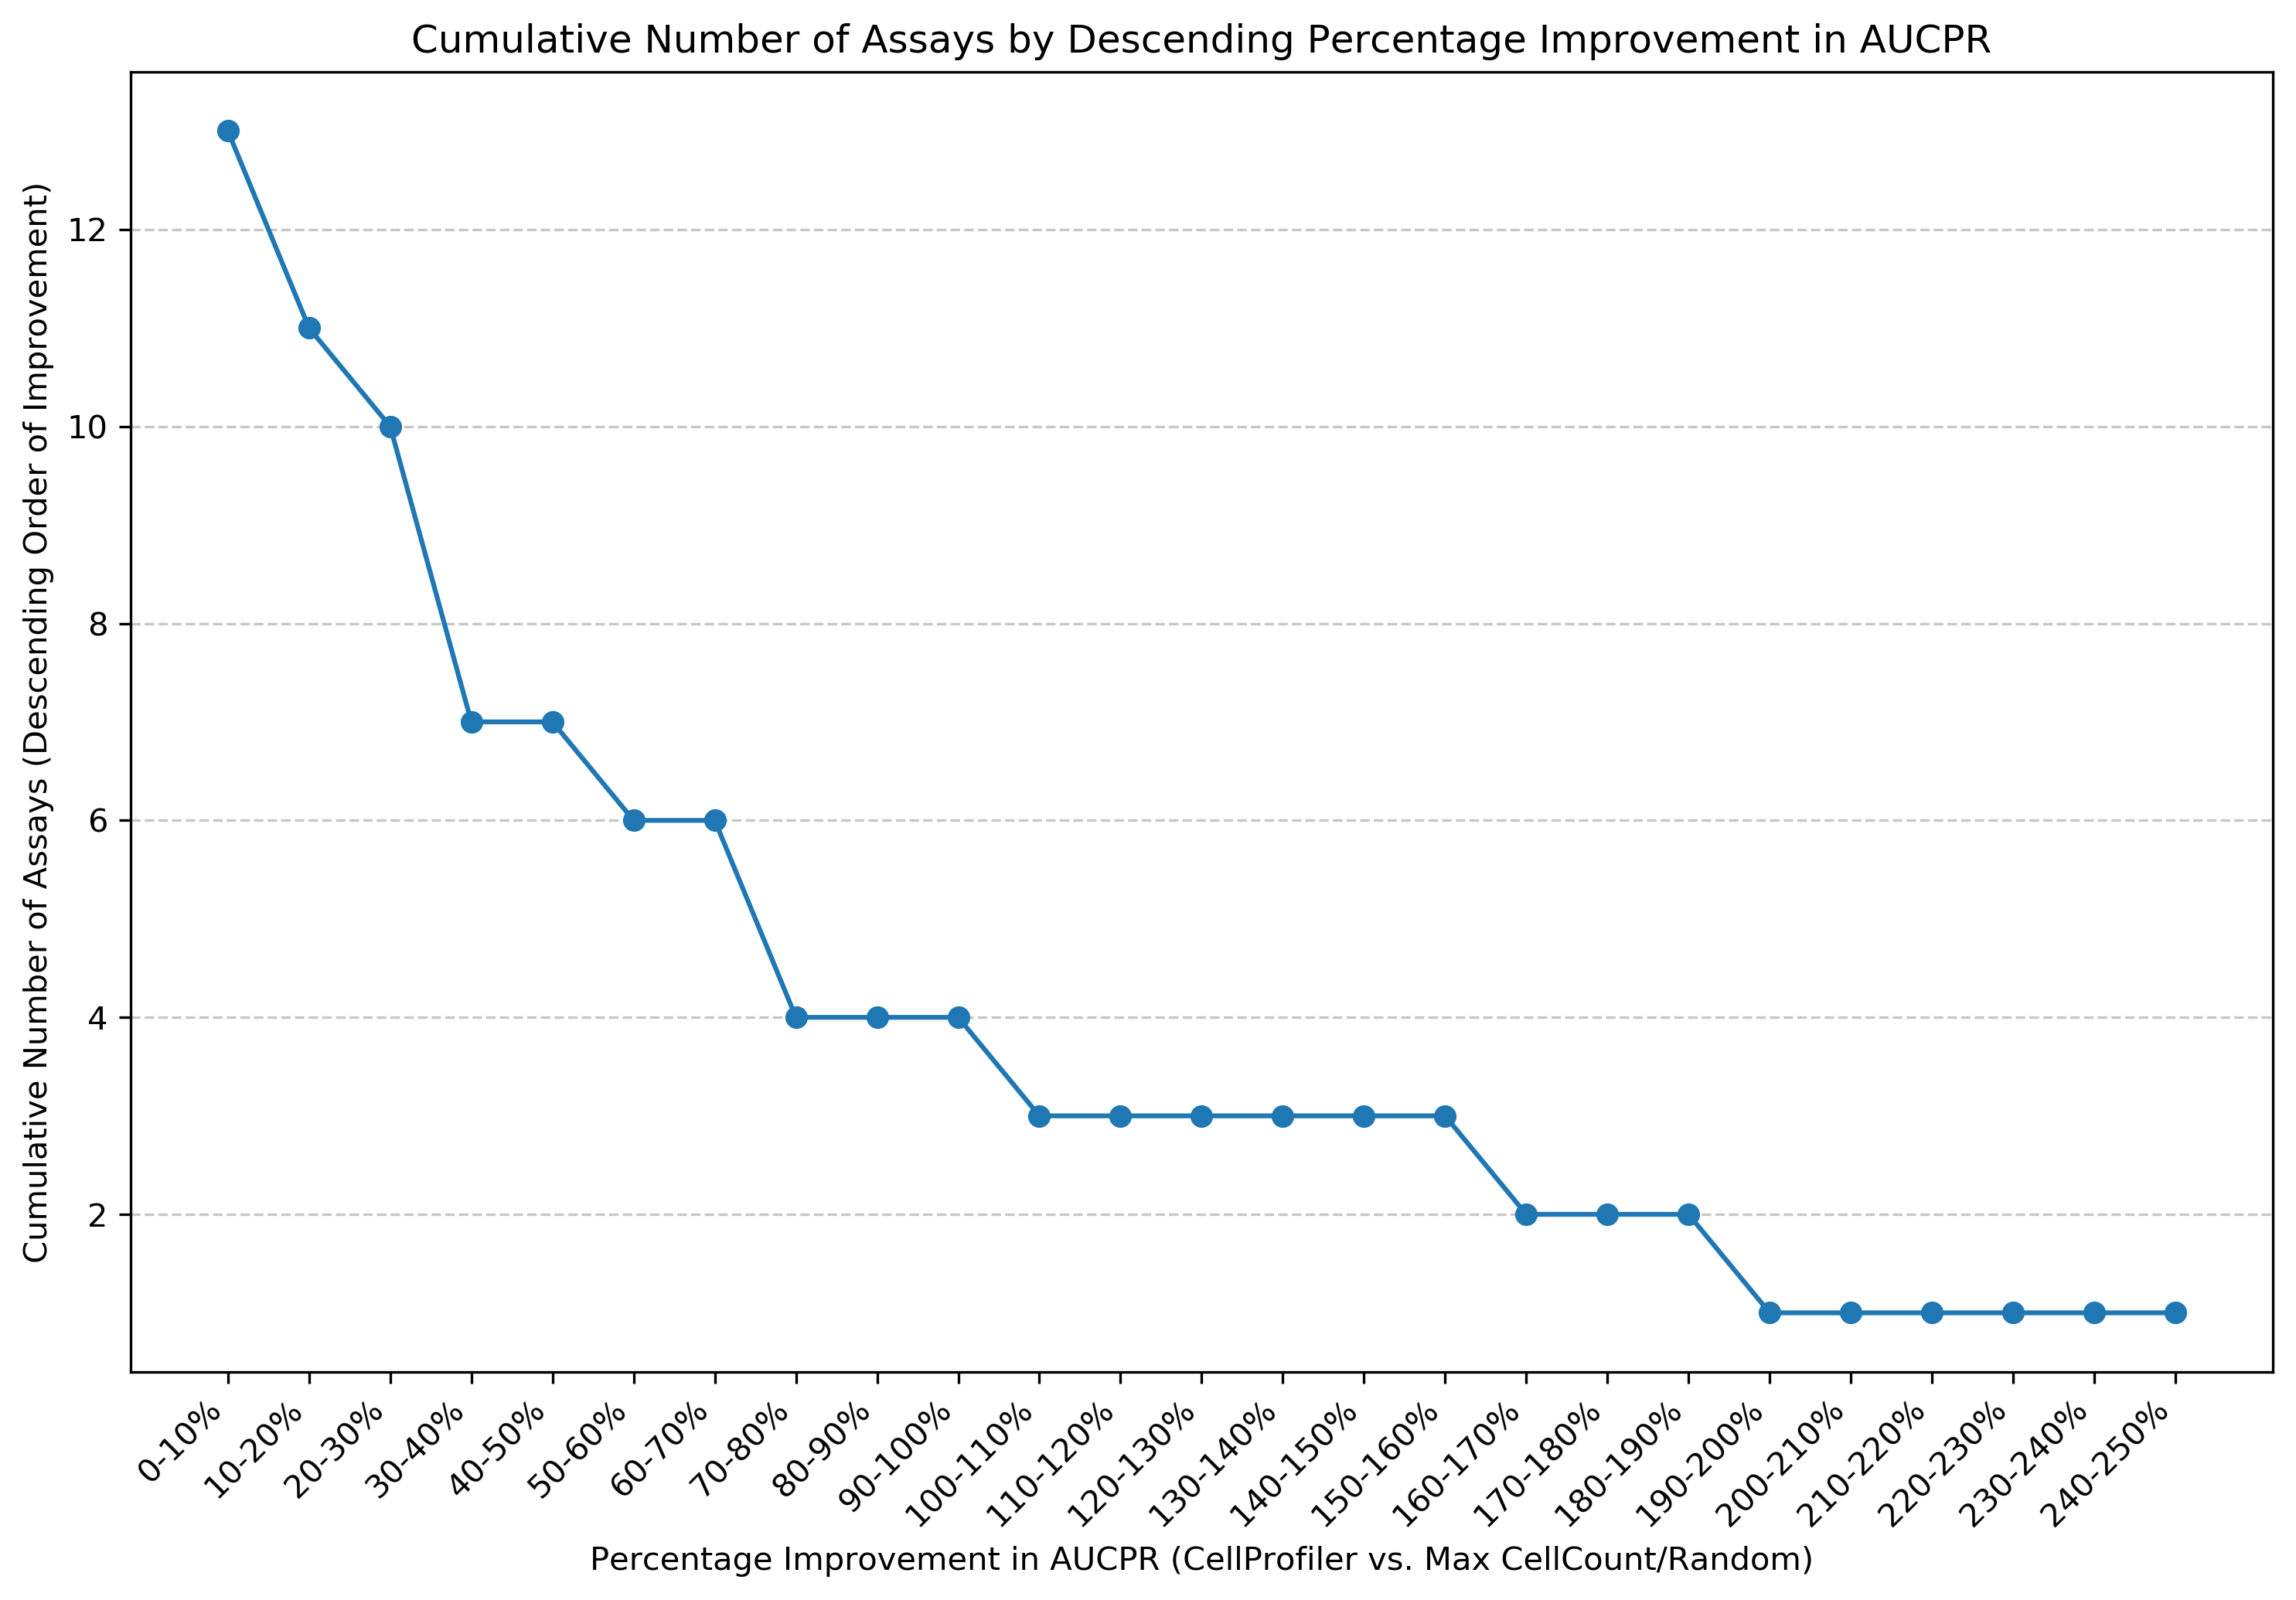

In [68]:
# Sort data for cumulative count starting from highest percentage improvement (100% to 0%)
reverse_cumulative_improvement = improvement_counts[::-1].cumsum()

# Line plot for reverse cumulative count of assays
plt.figure(figsize=(10, 7), dpi=300)
plt.plot(
    [f"{int(interval.left)}-{int(interval.right)}%" for interval in reverse_cumulative_improvement.index][::-1],
    reverse_cumulative_improvement.values[::-1],
    marker='o',
    linestyle='-'
)
plt.xlabel("Percentage Improvement in AUCPR (CellProfiler vs. Max CellCount/Random)")
plt.ylabel("Cumulative Number of Assays (Descending Order of Improvement)")
plt.title("Cumulative Number of Assays by Descending Percentage Improvement in AUCPR")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [59]:
cellprofiler_df

,Task,Fold,AUC,Optimal Threshold,Optimal Kappa,Kappa,Kappa @ 0.50,Balanced Accuracy,AUCPR,Sensitivity,...,Total Actives Test,Total Inactives Test,Total Compounds Test,Scrambled Kappa,Scrambled Balanced Accuracy,Random_AUCPR,Max_CellCount_Random_AUCPR,Better_AUCPR,Percentage_Improvement,Improvement_Bin
0,CHEMBL1741321,2.0,0.644740,0.370370,0.244311,0.212667,0.166193,0.610711,0.447370,0.469142,...,77.333333,204.666667,282.000000,-0.004177,0.498343,0.274232,0.352239,1.000000,27.007708,"(20.0, 30.0]"
1,CHEMBL1741322,2.0,0.624129,0.558923,0.184777,0.153322,0.205899,0.578873,0.658361,0.480186,...,143.000000,113.666667,256.666667,-0.018222,0.490743,0.557145,0.615677,0.333333,6.932852,"(0.0, 10.0]"
2,CHEMBL1741323,2.0,0.787935,0.441077,0.513692,0.523071,0.509154,0.759649,0.724661,0.694121,...,113.333333,169.666667,283.000000,0.033455,0.513988,0.400471,0.444219,1.000000,63.131592,"(60.0, 70.0]"
3,CHEMBL1741324,2.0,0.646289,0.390572,0.254066,0.215540,0.096731,0.616321,0.470926,0.616916,...,92.333333,168.333333,260.666667,-0.018427,0.491860,0.354219,0.384402,1.000000,22.508752,"(20.0, 30.0]"
4,CHEMBL1741325,2.0,0.783816,0.441077,0.476810,0.468361,0.480493,0.728880,0.659947,0.606931,...,87.333333,181.000000,268.333333,-0.011223,0.495701,0.325464,0.405313,1.000000,62.823866,"(60.0, 70.0]"
5,CHEMBL1909087,2.0,0.724990,0.164983,0.199663,0.086420,0.000000,0.551170,0.209107,0.166667,...,7.666667,114.000000,121.666667,0.000000,0.500000,0.063000,0.375762,0.333333,-44.351332,NaN
6,CHEMBL1909089,2.0,0.643761,0.114478,0.163744,0.067372,0.000000,0.554369,0.185736,0.315476,...,7.333333,114.333333,121.666667,0.000000,0.500000,0.060267,0.217371,0.666667,-14.553660,NaN
7,CHEMBL1909104,2.0,0.783514,0.202020,0.272023,0.232270,-0.004992,0.651672,0.288260,0.388889,...,8.666667,113.000000,121.666667,0.000000,0.500000,0.071219,0.535609,0.000000,-46.180953,NaN
8,CHEMBL1909105,2.0,0.797362,0.259259,0.287442,0.184435,0.000000,0.609211,0.294747,0.268519,...,8.333333,113.333333,121.666667,0.000000,0.500000,0.068487,0.379872,0.333333,-22.408808,NaN
9,CHEMBL1909141,2.0,0.645190,0.168350,0.308506,0.064146,0.000000,0.540799,0.115853,0.185185,...,9.000000,112.666667,121.666667,0.000000,0.500000,0.073974,0.382717,0.333333,-69.728766,NaN


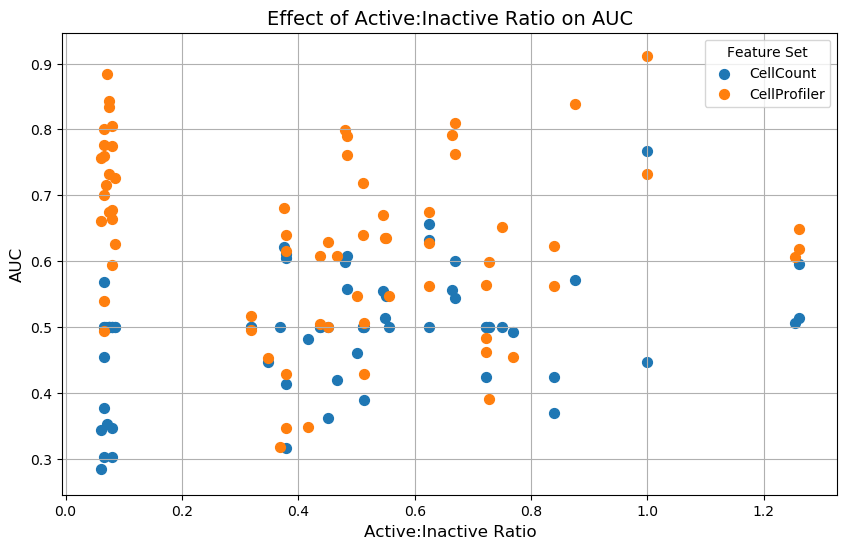

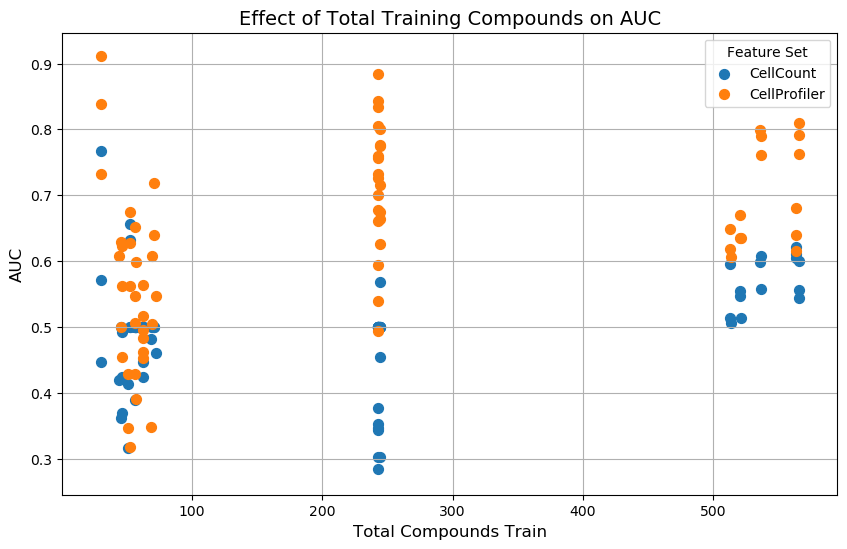

In [3]:
df = auc_df

# Adding a column for the ratio of actives to inactives in training data
df['Active:Inactive Ratio'] = df['Total Actives Train'] / df['Total Inactives Train']

# Plotting the relationship between Active:Inactive Ratio and AUC for each feature set
plt.figure(figsize=(10, 6))
for feature_set in df['Feature Set'].unique():
    subset = df[df['Feature Set'] == feature_set]
    plt.scatter(subset['Active:Inactive Ratio'], subset['AUC'], label=feature_set, s=50)

plt.title("Effect of Active:Inactive Ratio on AUC", fontsize=14)
plt.xlabel("Active:Inactive Ratio", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.legend(title="Feature Set", fontsize=10)
plt.grid(True)
plt.show()

# Plotting the relationship between total training compounds and AUC for each feature set
plt.figure(figsize=(10, 6))
for feature_set in df['Feature Set'].unique():
    subset = df[df['Feature Set'] == feature_set]
    plt.scatter(subset['Total Compounds Train'], subset['AUC'], label=feature_set, s=50)

plt.title("Effect of Total Training Compounds on AUC", fontsize=14)
plt.xlabel("Total Compounds Train", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.legend(title="Feature Set", fontsize=10)
plt.grid(True)
plt.show()

In [4]:
summary_stats

,Task,Feature Set,mean,std,count
0,CHEMBL1741321,CellCount,0.611807,0.008469,3
1,CHEMBL1741321,CellProfiler,0.644740,0.032582,3
2,CHEMBL1741322,CellCount,0.538551,0.049273,3
3,CHEMBL1741322,CellProfiler,0.624129,0.021618,3
4,CHEMBL1741323,CellCount,0.566648,0.030011,3
5,CHEMBL1741323,CellProfiler,0.787935,0.023335,3
6,CHEMBL1741324,CellCount,0.538004,0.021437,3
7,CHEMBL1741324,CellProfiler,0.646289,0.020089,3
8,CHEMBL1741325,CellCount,0.587978,0.027132,3
9,CHEMBL1741325,CellProfiler,0.783816,0.020101,3


In [5]:
overall_comparison

,Feature Set,mean,std
0,CellCount,0.491698,0.088986
1,CellProfiler,0.634396,0.136425


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CellCount v.s. CellProfiler: t-test independent samples with Bonferroni correction, P_val=1.030e-06 stat=-5.118e+00


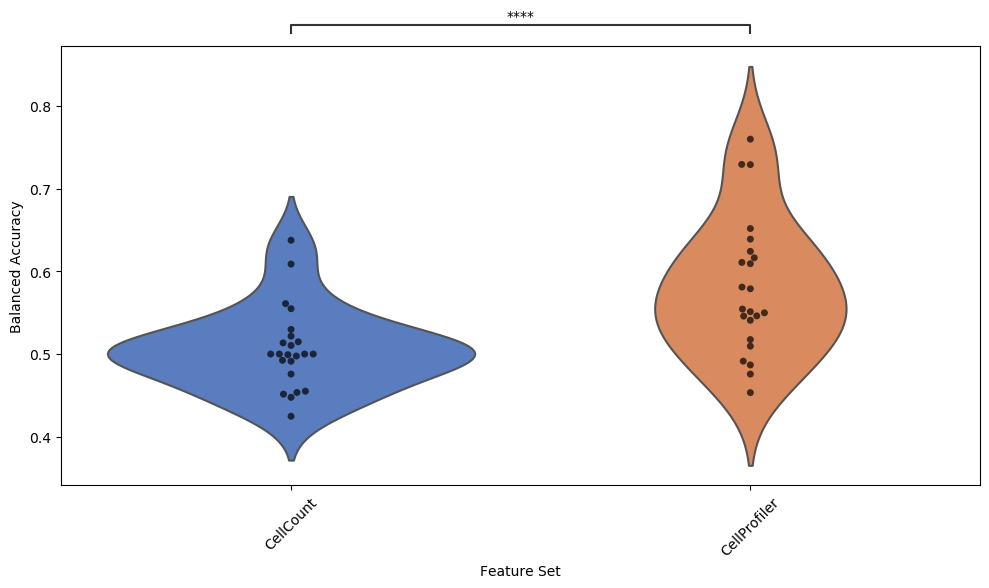

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation


# Create the violin plot with swarm overlay
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="Feature Set", y="Balanced Accuracy", data=auc_df.groupby(["Task","Feature Set"]).mean().reset_index(), inner=None, palette="muted")
sns.swarmplot(x="Feature Set", y="Balanced Accuracy", data=auc_df.groupby(["Task","Feature Set"]).mean().reset_index(), color="k", alpha=0.7)

# Add statistical annotations
add_stat_annotation(ax, data=auc_df, x="Feature Set", y="Balanced Accuracy",
                    box_pairs=[("CellCount", "CellProfiler")],
                    test="t-test_ind", text_format="star", loc="outside", verbose=2)

# Customize the plot
plt.xlabel("Feature Set")
plt.ylabel("Balanced Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CellCount v.s. CellProfiler: t-test independent samples with Bonferroni correction, P_val=2.457e-11 stat=-7.277e+00


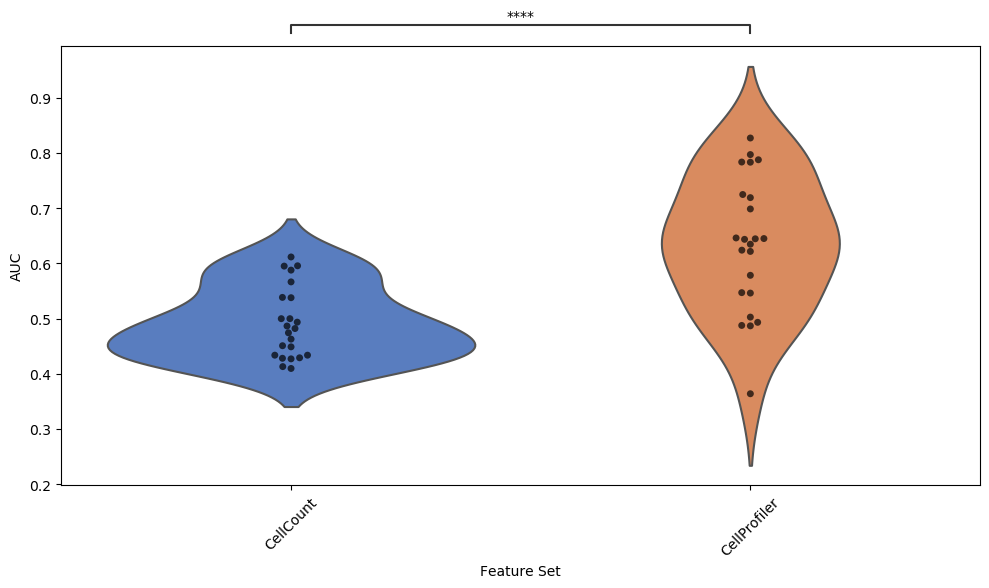

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation


# Create the violin plot with swarm overlay
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="Feature Set", y="AUC", data=auc_df.groupby(["Task","Feature Set"]).mean().reset_index(), inner=None, palette="muted")
sns.swarmplot(x="Feature Set", y="AUC", data=auc_df.groupby(["Task","Feature Set"]).mean().reset_index(), color="k", alpha=0.7)

# Add statistical annotations
add_stat_annotation(ax, data=auc_df, x="Feature Set", y="AUC",
                    box_pairs=[("CellCount", "CellProfiler")],
                    test="t-test_ind", text_format="star", loc="outside", verbose=2)

# Customize the plot
plt.xlabel("Feature Set")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


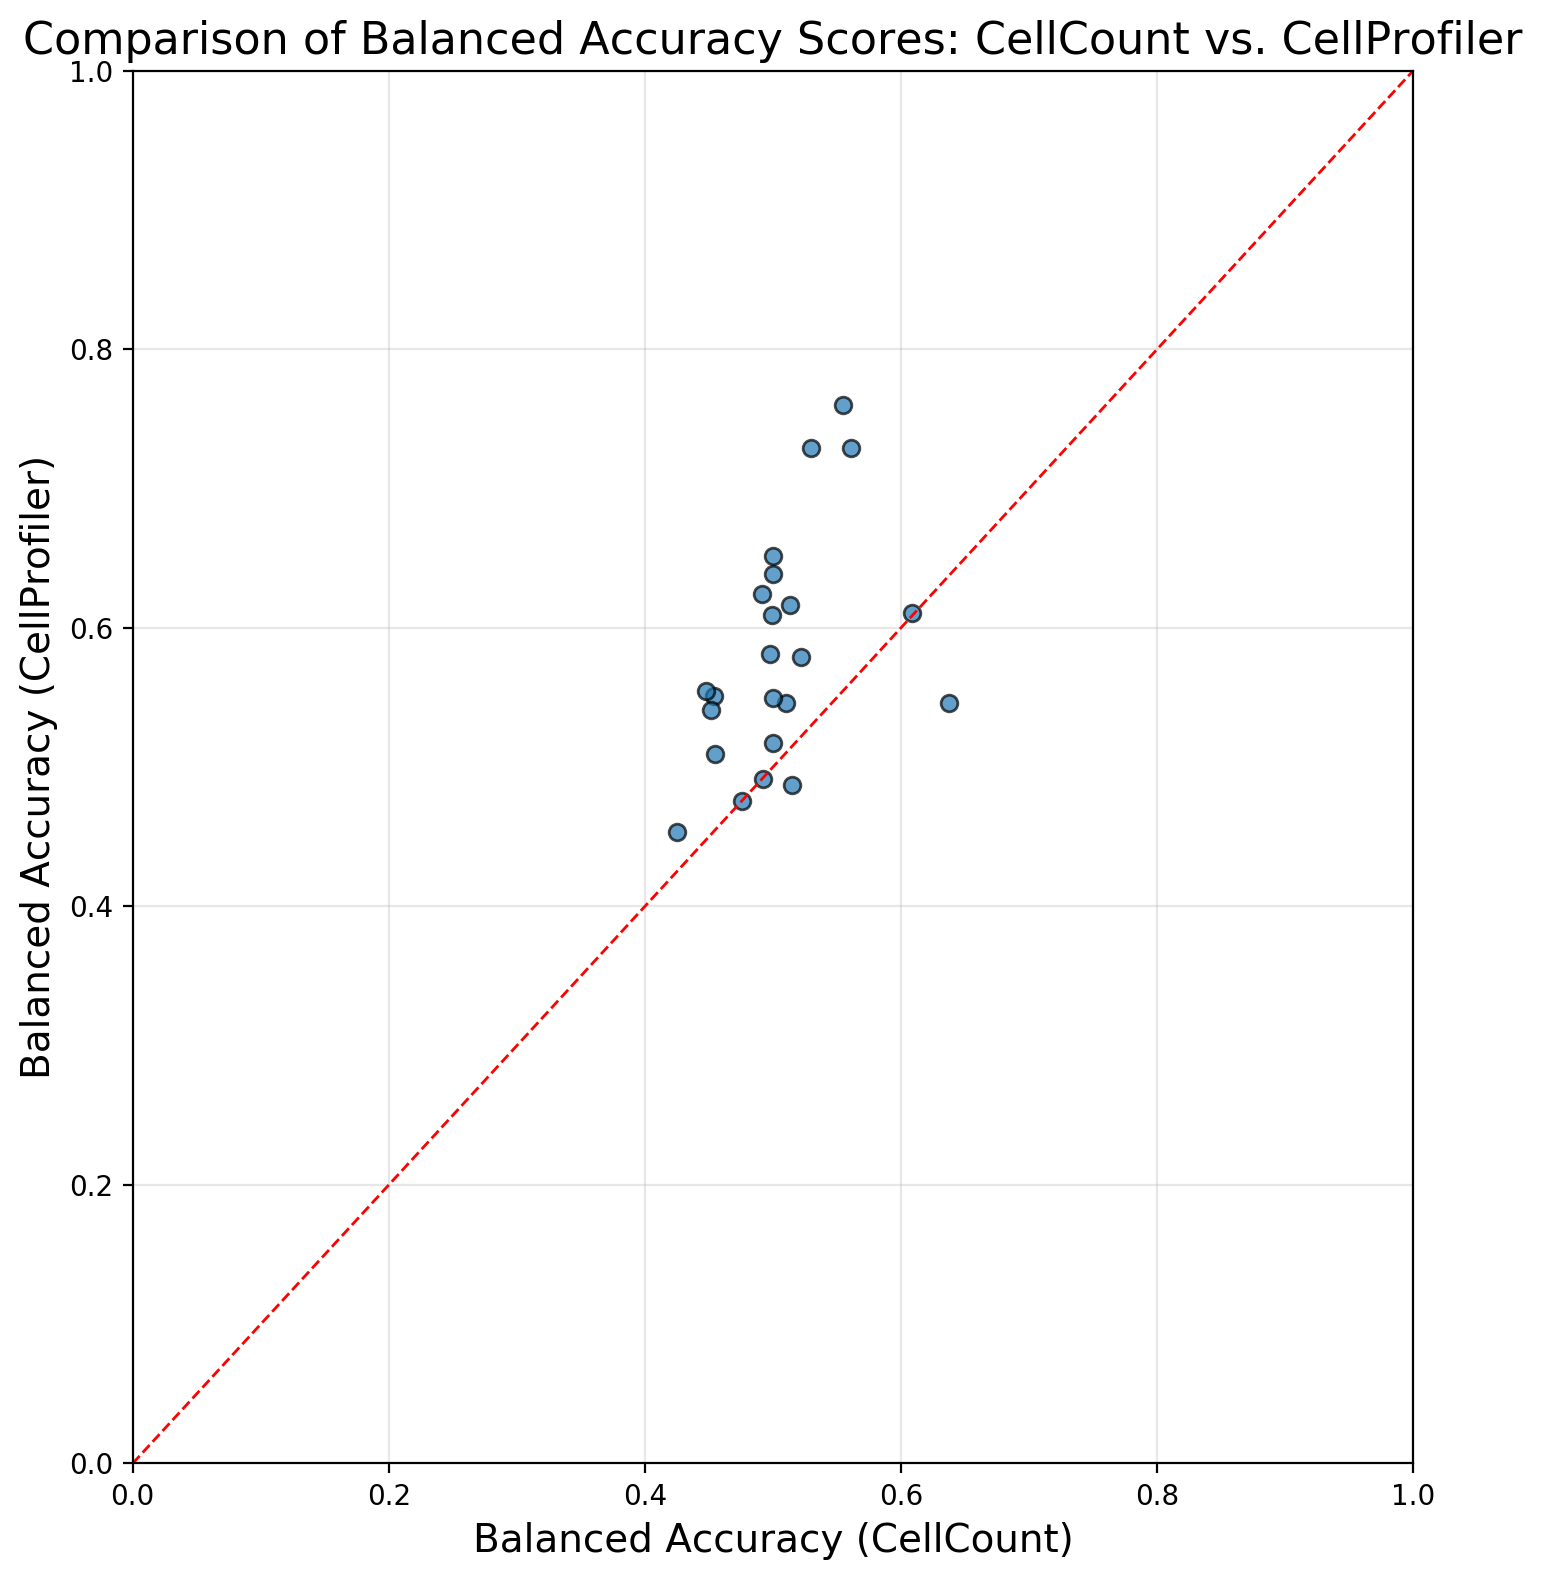

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
cellcount_data = auc_df[auc_df["Feature Set"] == "CellCount"].groupby(["Task","Feature Set"]).mean().reset_index()
cellprofiler_data = auc_df[auc_df["Feature Set"] == "CellProfiler"].groupby(["Task","Feature Set"]).mean().reset_index()

# Merge the data on Task
merged_data = pd.merge(
    cellcount_data, cellprofiler_data, on="Task", suffixes=("_CellCount", "_CellProfiler")
)

# Create the scatter plot
plt.figure(figsize=(8, 8), dpi=200)
plt.scatter(merged_data["Balanced Accuracy_CellCount"], merged_data["Balanced Accuracy_CellProfiler"], alpha=0.7, edgecolors="k")

# Add the x=y line
plt.plot([0, 1], [0, 1], color="red", linestyle="--", linewidth=1)

# Customize the plot
plt.title("Comparison of Balanced Accuracy Scores: CellCount vs. CellProfiler", fontsize=16)
plt.xlabel("Balanced Accuracy (CellCount)", fontsize=14)
plt.ylabel("Balanced Accuracy (CellProfiler)", fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


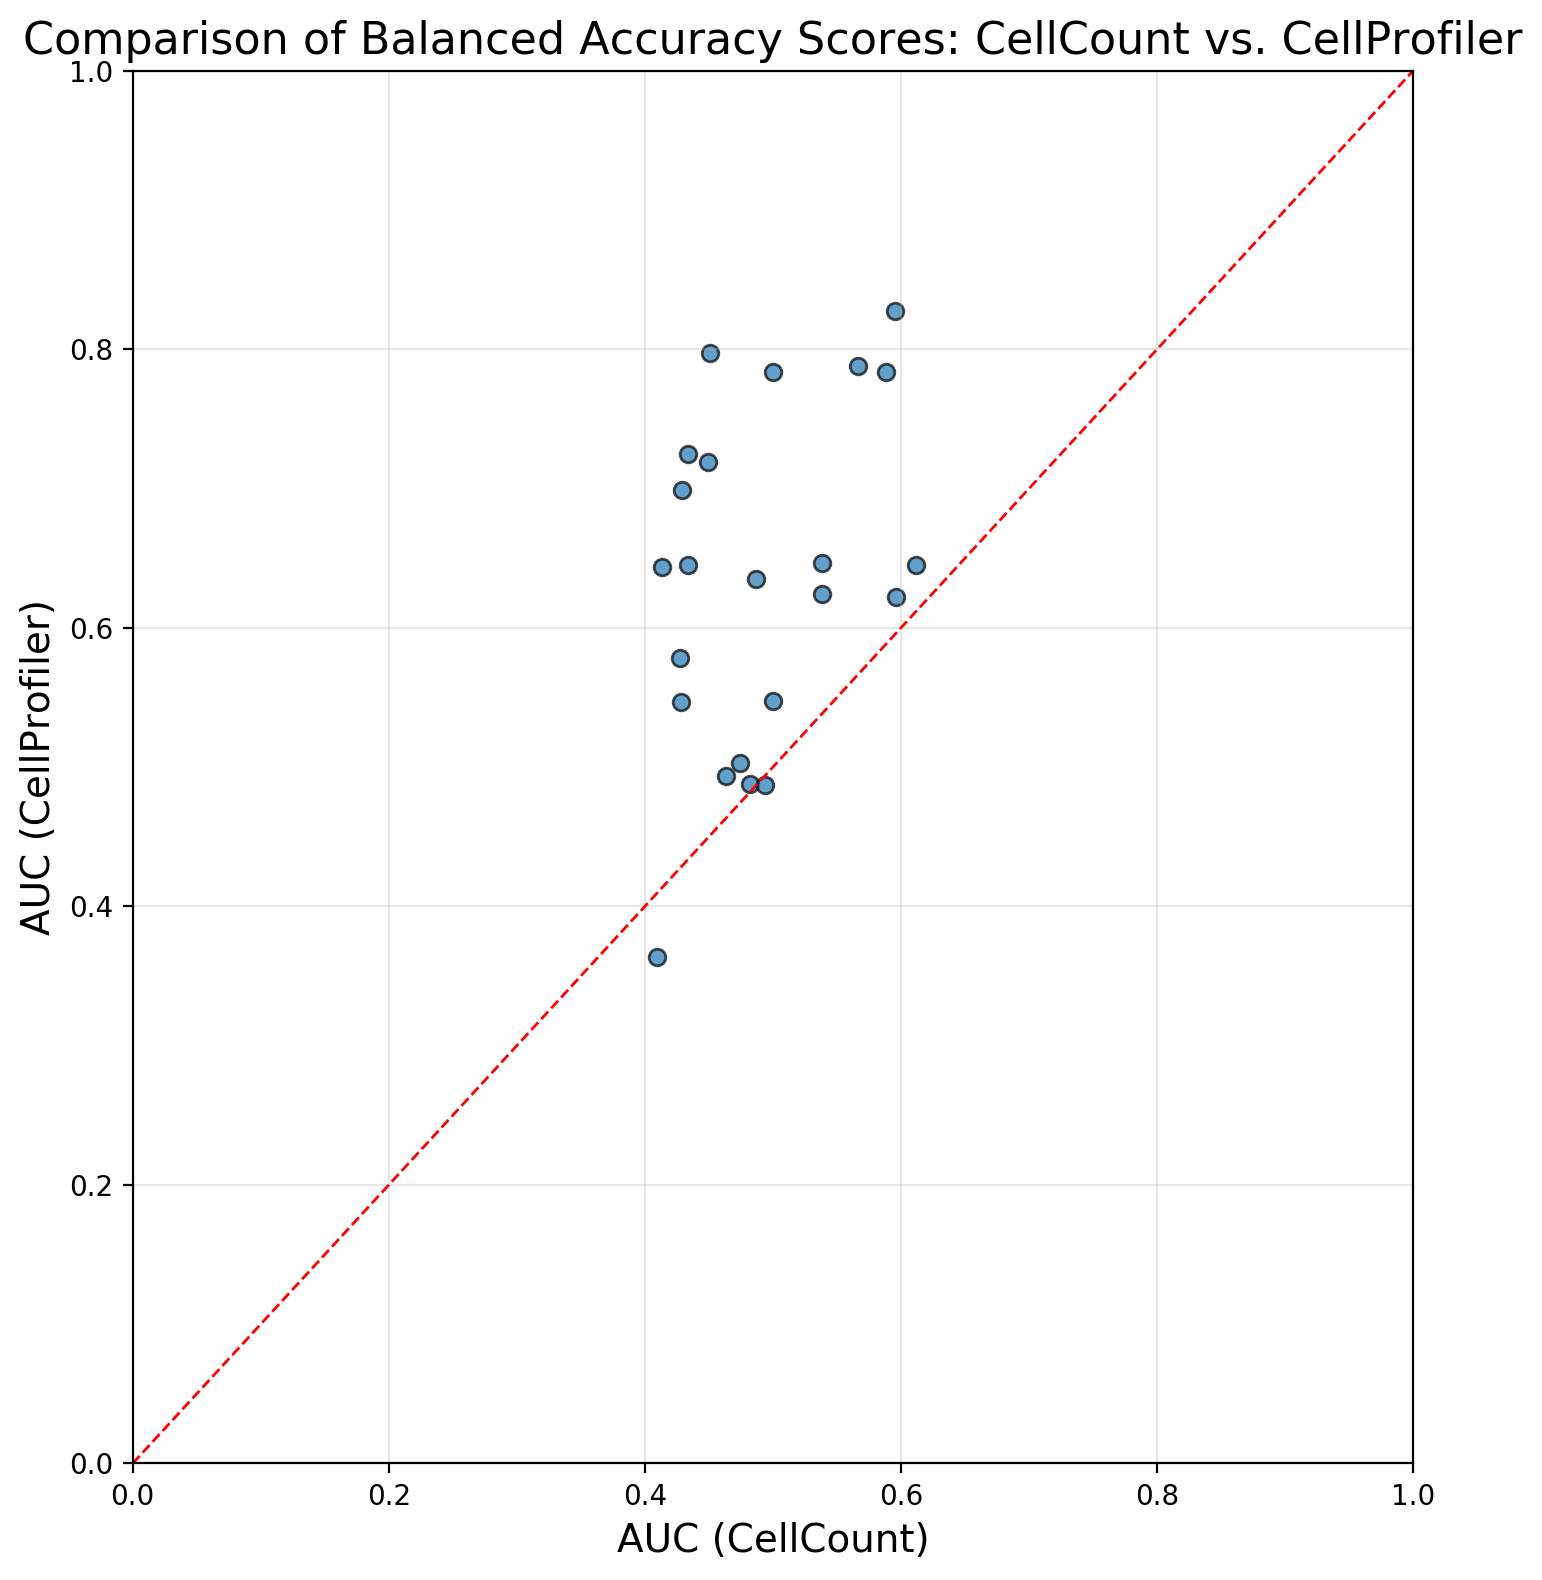

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data
cellcount_data = auc_df[auc_df["Feature Set"] == "CellCount"].groupby(["Task","Feature Set"]).mean().reset_index()
cellprofiler_data = auc_df[auc_df["Feature Set"] == "CellProfiler"].groupby(["Task","Feature Set"]).mean().reset_index()

# Merge the data on Task
merged_data = pd.merge(
    cellcount_data, cellprofiler_data, on="Task", suffixes=("_CellCount", "_CellProfiler")
)

# Create the scatter plot
plt.figure(figsize=(8, 8), dpi=200)
plt.scatter(merged_data["AUC_CellCount"], merged_data["AUC_CellProfiler"], alpha=0.7, edgecolors="k")

# Add the x=y line
plt.plot([0, 1], [0, 1], color="red", linestyle="--", linewidth=1)

# Customize the plot
plt.title("Comparison of Balanced Accuracy Scores: CellCount vs. CellProfiler", fontsize=16)
plt.xlabel("AUC (CellCount)", fontsize=14)
plt.ylabel("AUC (CellProfiler)", fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


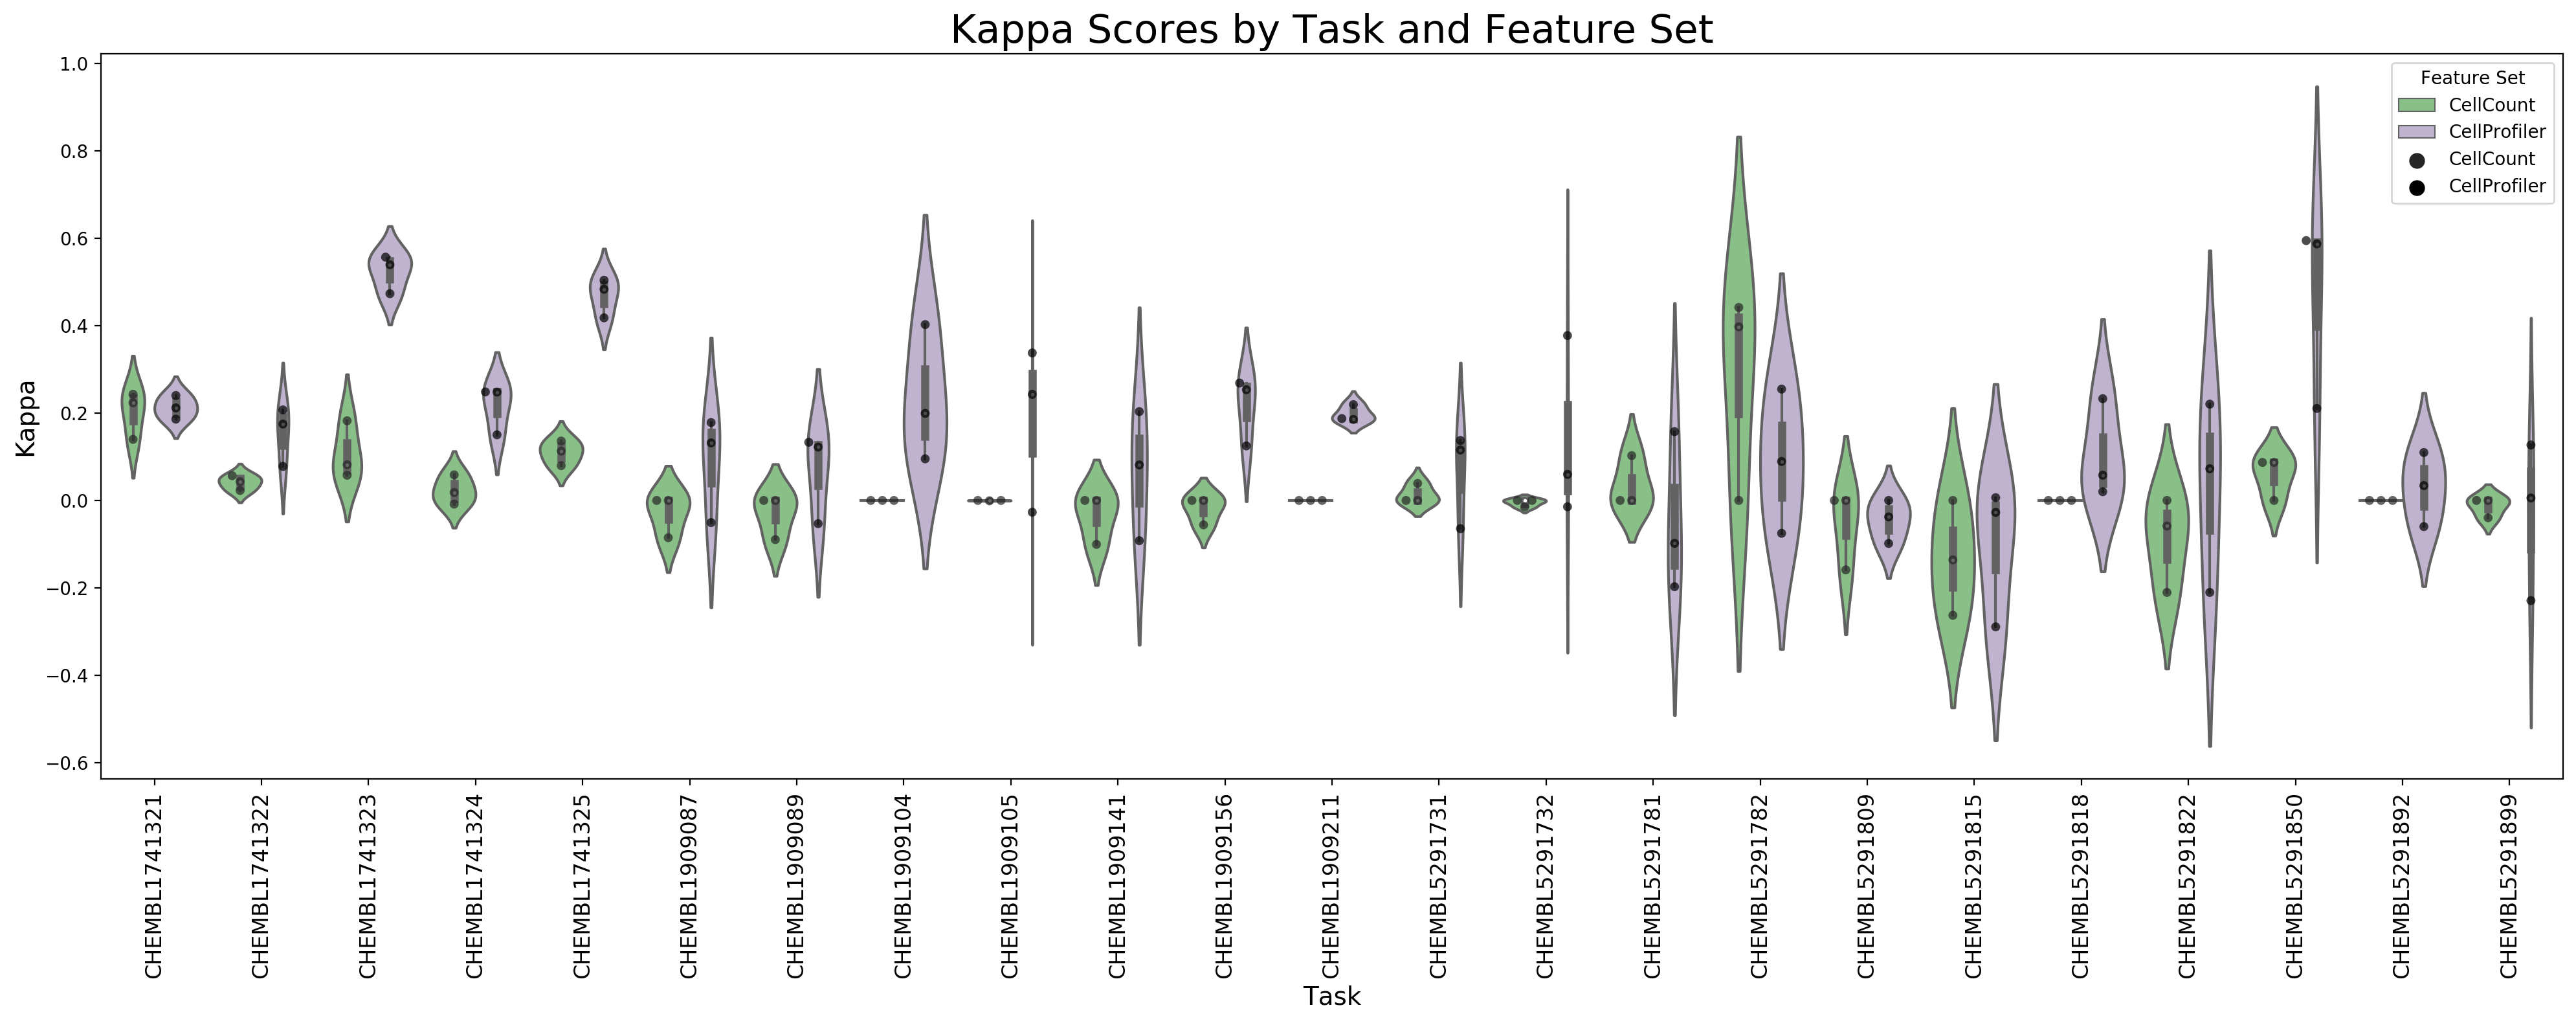

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create the violin plot with swarm overlay
plt.figure(figsize=(20, 8), dpi=200)
sns.violinplot(x="Task", y="Kappa", hue="Feature Set", data=auc_df, palette="Accent", dodge=True)
plt.legend(title="Feature Set", fontsize=12)

sns.swarmplot(x="Task", y="Kappa", hue="Feature Set", data=auc_df, color="k", alpha=0.7, dodge=True)

# Customize the plot
plt.title("Kappa Scores by Task and Feature Set", fontsize=22)
plt.xlabel("Task", fontsize=14)
plt.ylabel("Kappa", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()
